<a href="https://colab.research.google.com/github/RhysWangJunfei/PowerFlow/blob/main/bus30_ccgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
import sys
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from numpy.random import randn
from scipy.io import loadmat
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model,Sequential,Model
import math
import time
from tensorflow.keras.layers import Conv1D, MaxPooling1D,Lambda,Concatenate
import pdb; 
import scipy

In [3]:
mat_load = loadmat('/content/drive/MyDrive/Phd/opf_gan/IEEE30_load.mat')
fc_3056 = loadmat('/content/drive/MyDrive/Phd/opf_gan/feasible_conditions_3056.mat')['conditions_list']
fc_7796 = loadmat('/content/drive/MyDrive/Phd/opf_gan/feasible_conditions_7796.mat')['conditions_list']
fc_7838 = loadmat('/content/drive/MyDrive/Phd/opf_gan/feasible_conditions_7838.mat')['conditions_list']
fp_3056 = loadmat('/content/drive/MyDrive/Phd/opf_gan/feasible_points_3056.mat')['datapoints_list']
fp_7796 = loadmat('/content/drive/MyDrive/Phd/opf_gan/feasible_points_7796.mat')['datapoints_list']
fp_7838 = loadmat('/content/drive/MyDrive/Phd/opf_gan/feasible_points_7838.mat')['datapoints_list']

baseMVA = 100
case30_pload = mat_load['aa'][:,2]/baseMVA
case30_qload = mat_load['aa'][:,3]/baseMVA

real_conditions = np.concatenate([fc_3056,fc_7796,fc_7838],axis=0)[0:12000,:]
real_points = np.concatenate([fp_3056,fp_7796,fp_7838],axis=0)
real_vm = real_points[0:12000,0:30]
real_va = real_points[0:12000,30:60]
matpower_pq = real_points[0:12000,60:]
real_p = np.zeros(real_vm.shape)
real_q = np.zeros(real_vm.shape)
real_p[:,0] = matpower_pq[0:12000,0]
real_p[:,1] = matpower_pq[0:12000,1]
real_p[:,21] = matpower_pq[0:12000,2]
real_p[:,26] = matpower_pq[0:12000,3]
real_p[:,22] = matpower_pq[0:12000,4]
real_p[:,12] = matpower_pq[0:12000,5]
real_q[:,0] = matpower_pq[0:12000,6]
real_q[:,1] = matpower_pq[0:12000,7]
real_q[:,21] = matpower_pq[0:12000,8]
real_q[:,26] = matpower_pq[0:12000,9]
real_q[:,22] = matpower_pq[0:12000,10]
real_q[:,12] = matpower_pq[0:12000,11]

In [4]:
def define_generator(latent_dim):
  random_noise = keras.Input(shape=(latent_dim,))
  demand = keras.Input(shape=(60,))
  concat_layer= Concatenate()([random_noise, demand])
  hidden = layers.Dense(128,dtype='float32',activation='tanh')(concat_layer)
  #hidden = layers.Dropout(0.1)(hidden)
  hidden = layers.Dense(256,dtype='float32',activation='tanh')(hidden)
  #hidden = layers.Dense(512,dtype='float32',activation='tanh')(hidden)
  #hidden = layers.Dense(768,dtype='float32',activation='tanh')(hidden)
  #hidden = layers.Dense(512,dtype='float32',activation='tanh')(hidden)
  #hidden = layers.Dropout(0.1)(hidden)
  hidden = layers.Dense(128,dtype='float32',activation='tanh')(hidden)
  #hidden = layers.Dropout(0.1)(hidden)
  hidden = layers.Dense(64,dtype='float32',activation='tanh')(hidden)
  #hidden = layers.Dropout(0.1)(hidden)
  g_active = layers.Dense(30,dtype='float32',activation='sigmoid')(hidden)
  g_active = tf.math.multiply(g_active,tf.constant([0.8,0.8,0,0,0,0,0,0,0,0,\
                                                    0,0,0.4,0,0,0,0,0,0,0,\
                                                    0,0.5,0.3,0,0,0,0.55,0,0,0],dtype='float32'))
  g_reactive = layers.Dense(30,dtype='float32',activation='sigmoid')(hidden)
  g_reactive = tf.math.multiply(g_reactive,tf.constant([1.7,0.8,0,0,0,0,0,0,0,0,\
                                                        0,0,0.597,0,0,0,0,0,0,0,\
                                                        0,0.775,0.5,0,0,0,0.637,0,0,0],dtype='float32'))\
                                                    +tf.constant([-0.2,-0.2,0,0,0,0,0,0,0,0,\
                                                    0,0,-0.15,0,0,0,0,0,0,0,0,-0.15,-0.1,0,0,\
                                                    0,-0.15,0,0,0],dtype='float32')
  bus_vm = layers.Dense(30,dtype='float32',activation='sigmoid')(hidden)
  bus_vm = tf.math.multiply(bus_vm,tf.constant([0,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,\
                                                0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,\
                                                0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2],\
                                               dtype='float32'))+tf.constant(\
                                                [1,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,\
                                                0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,\
                                                0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9],\
                                                dtype='float32')
  bus_va = layers.Dense(30,dtype='float32',activation='sigmoid')(hidden)
  bus_va = tf.math.multiply(bus_va,tf.constant([0,360,360,360,360,360,360,360,360,360,\
                                                360,360,360,360,360,360,360,360,360,360,\
                                                360,360,360,360,360,360,360,360,360,360],\
                                               dtype='float32'))
  g_model = keras.Model(inputs=[random_noise,demand], outputs=[g_active,g_reactive,bus_vm,bus_va])
  return g_model

def define_discriminator():
  demand = keras.Input(shape=(60,))
  g_active = keras.Input(shape=(30,))
  g_reactive = keras.Input(shape=(30,))
  bus_vm = keras.Input(shape=(30,))
  bus_va = keras.Input(shape=(30,))
  concat_layer= Concatenate()([demand,g_active,g_reactive,bus_vm,bus_va])
  hidden = layers.Dense(256,dtype='float32',activation='tanh')(concat_layer)
  hidden = layers.Dense(64,dtype='float32',activation='tanh')(hidden)
  hidden = layers.Dense(8,dtype='float32',activation='tanh')(hidden)
  out_layer = layers.Dense(1,dtype='float32',activation='sigmoid')(hidden)
  #define model
  d_model = Model([demand,g_active,g_reactive,bus_vm,bus_va], out_layer)
  #compile model
  opt = tf.keras.optimizers.Adam(learning_rate=0.000001, beta_1=0.5)
  d_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return d_model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable
  d_model.trainable = False
  [g_active,g_reactive,bus_vm,bus_va] = generator.output
  [gen_noise, gen_label] = generator.input
  gan_output = d_model([gen_label,g_active,g_reactive,bus_vm,bus_va])
  # define gan model as taking noise and label and outputting a classification
  model = Model([gen_noise, gen_label], gan_output)
  # compile model
  opt = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [5]:
def rdm_load_pq_20per(case_pload,case_qload,sample_number):
    number_of_bus = case_pload.shape[0]
    p_demand = np.zeros([sample_number,number_of_bus])
    q_demand = np.zeros([sample_number,number_of_bus])
    for i in range(0,number_of_bus):
        pi = case_pload[i]
        qi = case_qload[i]
        if case_pload[i]!=0:
          p_mw = np.random.uniform(pi*0.8,pi*1.2,sample_number)
          q_mvar = np.random.uniform(qi*0.8,qi*1.2,sample_number)
          p_demand[:,i] = p_mw
          q_demand[:,i] = q_mvar
    return p_demand,q_demand

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  z_input = x_input.reshape(n_samples, latent_dim)
  # generate labels
  p_demand,q_demand = rdm_load_pq_20per(case30_pload,case30_qload,n_samples)
  labels = np.concatenate([p_demand,q_demand],axis=1)
  return [z_input, labels]

# select real samples
def generate_real_samples(n_samples):
  # choose random instances
  ix = np.random.randint(0, 12000, n_samples)
  # select images and labels
  batch_condition,batch_vm,batch_va,batch_p,batch_q = real_conditions[ix], \
    real_vm[ix], real_va[ix], real_p[ix], real_q[ix]
  # generate class labels
  y = np.ones((n_samples, 1))
  return batch_condition,batch_vm,batch_va,batch_p,batch_q, y

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = np.zeros((n_samples, 1))
	return labels_input,images, y

def summarize_performance(g_model, d_model, latent_dim, n_samples=100):
  # prepare real samples
  batch_condition,batch_vm,batch_va,batch_p,batch_q, y_real = generate_real_samples(batch_size)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate([batch_condition,batch_p,batch_q,batch_vm,batch_va], y_real, verbose=0)
  # prepare fake examples
  fake_demand, [fake__p,fake__q,fake_vm,fake_va], fake_y = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate([fake_demand,fake__p,fake__q,fake_vm,fake_va], fake_y, verbose=0)
  # summarize discriminator performance
  #pdb.set_trace()
  print('>Accuracy real: %.3f%%, fake: %.3f%%' % (acc_real*100, acc_fake*100))
  return acc_real*100,acc_fake*100

In [ ]:
batch_condition,batch_vm,batch_va,batch_p,batch_q, y_real = generate_real_samples(batch_size)
fake_demand, [fake__p,fake__q,fake_vm,fake_va], fake_y = generate_fake_samples(generator, latent_dim, batch_size)

In [ ]:
discriminator.predict([fake_demand,fake__p,fake__q,fake_vm,fake_va])

In [12]:
latent_dim = 10
batch_size = 16
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)

batch_condition,batch_vm,batch_va,batch_p,batch_q, y = generate_real_samples(batch_size)

fake_demand, [fake_p,fake_q,fake_vm,fake_va], fake_y = generate_fake_samples(generator, \
                                                                               latent_dim, batch_size)
real_acc_list = []
fake_acc_list = []

In [13]:
iterations = 100000
d_loss1 = 0
d_loss2 = 0
for i in range(iterations):
  with tf.GradientTape(persistent=True) as tape:
    discriminator.trainable=True
    d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    # get randomly selected 'real' samples
    batch_condition, batch_vm,batch_va,batch_p,batch_q, y_real = generate_real_samples(batch_size//2)
    # generate 'fake' examples
    [z_input, fake_demand] = generate_latent_points(latent_dim, batch_size)
    fake_demand = tf.keras.backend.variable(fake_demand)
    tape.watch(fake_demand)
    [g_active,g_reactive,bus_vm,bus_va] = generator([z_input, fake_demand])
    if i%15==0:
      # update discriminator model weights
      d1_prob = discriminator([batch_condition,batch_p,batch_q,batch_vm,batch_va])
      d2_prob = discriminator([fake_demand[0:batch_size//2],fake_p[0:batch_size//2],fake_q[0:batch_size//2],\
                              fake_vm[0:batch_size//2],fake_va[0:batch_size//2]])
      d1_loss = -tf.reduce_mean(d1_prob)
      d2_loss = tf.reduce_mean(d2_prob)
      d1_grads = tape.gradient(d1_loss,discriminator.trainable_weights)
      d2_grads = tape.gradient(d2_loss,discriminator.trainable_weights)
      d_optimizer.apply_gradients(zip(d1_grads, discriminator.trainable_weights))
      d_optimizer.apply_gradients(zip(d2_grads, discriminator.trainable_weights))
    # create inverted labels for the fake samples
    # update the generator via the discriminator's error
    
    g_prob = gan_model([z_input,fake_demand])
    loss = -tf.reduce_mean(g_prob)
    dy_dx = tf.reduce_mean(tape.gradient(g_prob, fake_demand))
    discriminator.trainable=False
    gan_grads = tape.gradient(loss+dy_dx, gan_model.trainable_weights)
    g_optimizer.apply_gradients(zip(gan_grads, gan_model.trainable_weights))

    # summarize loss on this batch
  real_acc,fake_acc = summarize_performance(generator, discriminator,latent_dim, n_samples=100)
  real_acc_list.append(real_acc)
  fake_acc_list.append(fake_acc)
# save the generator model


Streaming output truncated to the last 5000 lines.
>Accuracy real: 100.000%, fake: 100.000%
>Accuracy real: 100.000%, fake: 100.000%
>Accuracy real: 100.000%, fake: 100.000%
>Accuracy real: 100.000%, fake: 100.000%
>Accuracy real: 100.000%, fake: 100.000%
>Accuracy real: 100.000%, fake: 100.000%
>Accuracy real: 100.000%, fake: 100.000%
>Accuracy real: 100.000%, fake: 100.000%
>Accuracy real: 100.000%, fake: 100.000%
>Accuracy real: 100.000%, fake: 100.000%
>Accuracy real: 100.000%, fake: 100.000%
>Accuracy real: 100.000%, fake: 100.000%
>Accuracy real: 100.000%, fake: 100.000%
>Accuracy real: 100.000%, fake: 100.000%
>Accuracy real: 100.000%, fake: 100.000%
>Accuracy real: 100.000%, fake: 100.000%
>Accuracy real: 100.000%, fake: 100.000%
>Accuracy real: 100.000%, fake: 100.000%
>Accuracy real: 100.000%, fake: 100.000%
>Accuracy real: 100.000%, fake: 100.000%
>Accuracy real: 100.000%, fake: 100.000%
>Accuracy real: 100.000%, fake: 100.000%
>Accuracy real: 100.000%, fake: 100.000%
>Accur

In [11]:
dy_dx

<tf.Tensor: shape=(), dtype=float32, numpy=-10990.868>

In [37]:
print(tape.gradient(prob, fake_demand[0:batch_size//2]))

None


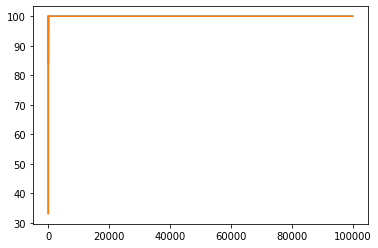

In [14]:
plt.plot(real_acc_list)
plt.plot(fake_acc_list)
plt.show()

In [ ]:
gan_grads

[<tf.Tensor: shape=(70, 128), dtype=float32, numpy=
 array([[ 4.20260839e-08,  2.33872569e-07,  4.65907455e-08, ...,
         -5.63618414e-07,  1.11417819e-09,  1.65941060e-07],
        [-1.81042083e-07, -3.77169357e-07,  1.93202183e-07, ...,
         -7.08489381e-07,  4.10053502e-07, -4.85649991e-07],
        [ 2.03395871e-07,  1.76142322e-07,  4.09961245e-07, ...,
          3.92479137e-07, -1.23145156e-07,  8.94219909e-07],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.75329351e-08, -2.26137917e-08,  3.31962879e-09, ...,
         -7.70536275e-08,  2.03794226e-08, -1.18803705e-08],
        [-3.61424668e-08, -4.63848728e-08,  6.87331791e-09, ...,
         -1.57894888e-07,  4.17470574e-08, -2.41003928e-08]], dtype=float32)>,
 <tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-1.9363663e-06, -2.4788601e-06,  3.7189565e-07, -1.0625997e-06,
        -1.9196300e-06, -4.8451602e-06, 

In [ ]:
generator.save('cgan_generator.h5')

In [23]:
 fake_demand, [fake__p,fake__q,fake_vm,fake_va], y_fake = generate_fake_samples(generator, \
                                                                              latent_dim, 1)

In [24]:
fake_demand

array([[0.        , 0.24846508, 0.01924916, 0.06470163, 0.        ,
        0.        , 0.18805556, 0.27151121, 0.        , 0.05250586,
        0.        , 0.12282557, 0.        , 0.06328692, 0.08478   ,
        0.03839997, 0.08841271, 0.0337252 , 0.09913385, 0.01814824,
        0.17347073, 0.        , 0.03440715, 0.09777008, 0.        ,
        0.04123653, 0.        , 0.        , 0.02801071, 0.08767175,
        0.        , 0.10998431, 0.01220339, 0.01527269, 0.        ,
        0.        , 0.10303169, 0.32100461, 0.        , 0.02203429,
        0.        , 0.07599914, 0.        , 0.01754042, 0.02340512,
        0.01870031, 0.04927253, 0.0084836 , 0.02725984, 0.00693341,
        0.1105616 , 0.        , 0.01399829, 0.05931138, 0.        ,
        0.02336459, 0.        , 0.        , 0.00937089, 0.01913919]])

In [26]:
np.sum(fake_demand[0:30])

2.9026392126004086